# Travail personnel MIG

# Mise en place de base

In [17]:
!curl -sSL -q -o - "https://cloud.minesparis.psl.eu/index.php/s/MGp21fRa8LEzO3f/download?path=%2F&files=mig25_data.tgz" | tar -xzv

data/
data/TA_1d.csv
data/TP_1d.csv
data/CF_1d.csv


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


sns.set_style('whitegrid')

# Fonction d'affichage des résultats

In [19]:
def display_result(y_true, y_pred):
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    seasons = y_true.index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : 
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()

# Mise en place des données

In [20]:
cf = pd.read_csv("data/CF_1d.csv", index_col = "Date", parse_dates = True)
ta = pd.read_csv("data/TA_1d.csv", index_col = "Date", parse_dates = True)
tp = pd.read_csv("data/TP_1d.csv", index_col = "Date", parse_dates = True)

cf_FR = cf[["FR"]]
ta_FR = ta[ta.columns[ta.columns.str.startswith("FR")]]
tp_FR = tp[tp.columns[tp.columns.str.startswith("FR")]]

data = pd.concat([ta.mean(axis=1).rename("TA"),
                  tp.mean(axis=1).rename("TP"),
                  cf["FR"].rename("CF")], axis=1)

On met en place une fonction qui crée les données avec des fenêtres données. On retient pour la moyenne nationale des fenêtres de 14 et 90 jours respectivement pour les températures et précipitations respectivement.

In [21]:
def crée_rolling(w1,w2): # w1 fenêtre pour les températures, w2 celle pour les précipitations
    X = pd.merge(ta_FR.rolling(window=w1, min_periods=1).mean(), tp_FR.rolling(window=w2, min_periods=1).sum(), 
                 left_index = True, right_index = True, suffixes = ("_TA", "_TP"))
    # on fait une somme glissante pour la pluvio et une moyenne glissante pour les températures
    y = data["CF"]
    return X,y

X, y = crée_rolling(14,90) # on retient les valeurs optimisées

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std["cos"] = np.cos(X_train_std.index.dayofyear * 2 * np.pi/365)
X_train_std["sin"] = np.sin(X_train_std.index.dayofyear * 2 * np.pi/365)

X_test_std["cos"] = np.cos(X_test_std.index.dayofyear * 2 * np.pi/365)
X_test_std["sin"] = np.sin(X_test_std.index.dayofyear * 2 * np.pi/365)

# Random Forest Regressor

On utilise les données avec les fenêtres rolling optimisées (14 jours pour la température, 90 pour les précipitations).

D'abord sans GridSearch :

R2: 0.187747
MSE: 0.008763



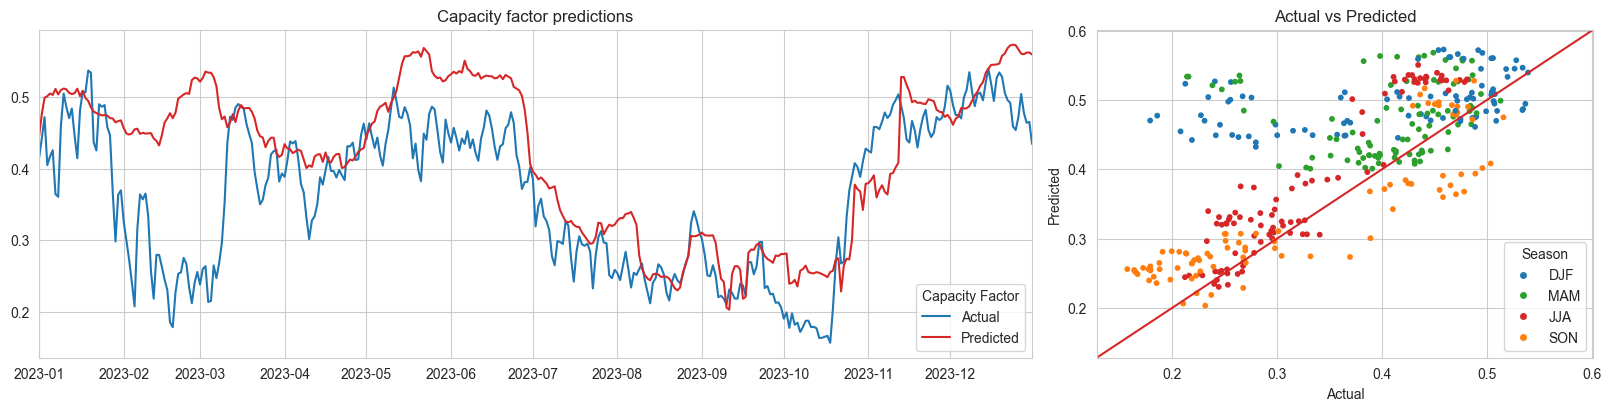

In [22]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train_std, y_train)  # apprentissage supervisé

y_pred = rfr.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["Random Forest"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Paramètres

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result(y_test, y_pred)

Avec GridSearch : on optimise les paramètres n estimators et max depth. On retient les valeurs suivantes : n estimators = 76 ; max depth = 6

In [23]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': np.arange(1,100),
              'max_depth': np.arange(1,100)
}

reg = RandomForestRegressor(random_state=0)  # modèle d'arbre de décision
cv = GridSearchCV(reg, param_grid=params, n_jobs = 2)  # recherche par grille. CV pour cross validation.
cv.fit(X_train_std, y_train)  # apprentissage supervisé

y_pred = cv.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RFRCV"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print(cv.best_params_)
print()

display_result(y_test, y_pred)

KeyboardInterrupt: 

Avec K-Fold Validation. On retient les paramètres : n estimators = ; max depth = .

R2: 0.045283
MSE: 0.010300



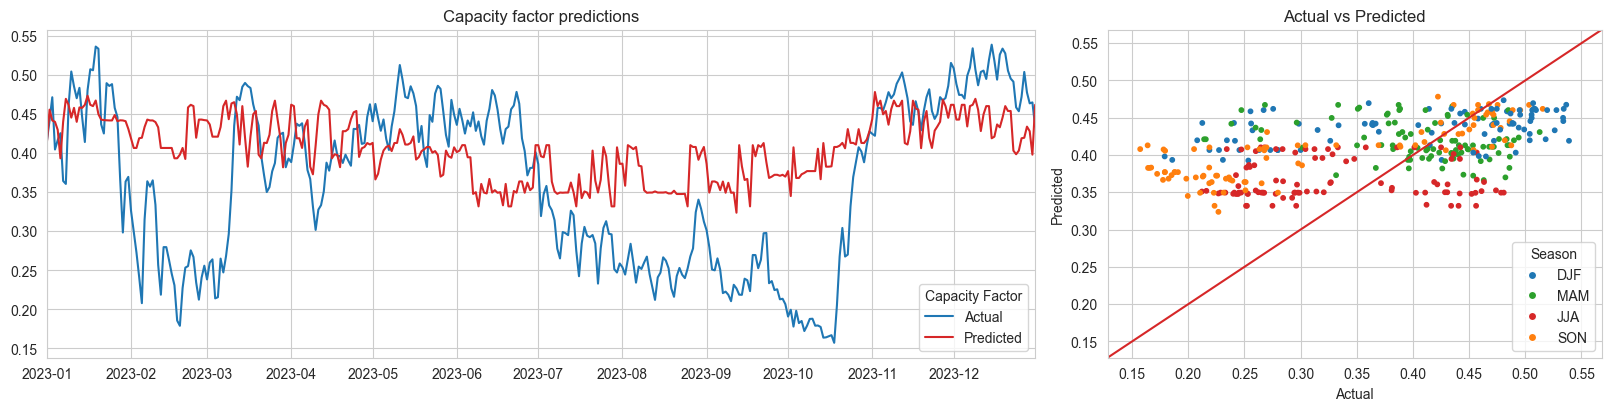

In [43]:
from sklearn.model_selection import GroupKFold

params = {'n_estimators': np.arange(1,100,1),
              'max_depth': np.arange(1,100,1)
}


gkf=GroupKFold(n_splits=8, shuffle = False)

n_samples = X_train.shape[0]            # 2920
n_groups = 8
group_size = n_samples // n_groups      # 365

groups = np.repeat(np.arange(n_groups), group_size)

reg = RandomForestRegressor(random_state=0)  # modèle d'arbre de décision
cv = GridSearchCV(reg, param_grid=params, n_jobs = 2, cv = gkf)  # recherche par grille. CV pour cross validation.
cv.fit(X_train_std, y_train, groups = groups)  # apprentissage supervisé

y_pred = cv.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RFRCVK-folds"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print(cv.best_params_)
print()

display_result(y_test, y_pred)

Refaire la même chose mais avec le leave one out. On retient les paramètres : n estimators = ; max depth = .

R2: 0.045283
MSE: 0.010300



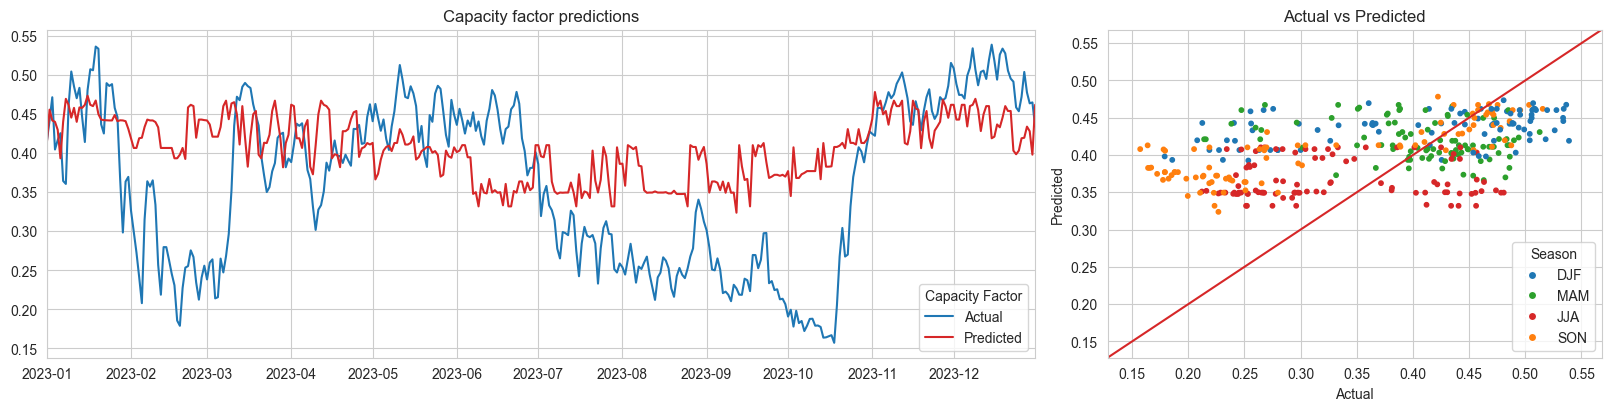

In [44]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()

params = {'n_estimators': np.arange(1,100),
              'max_depth': np.arange(1,100)
}

n_samples = X_train_std.shape[0]            # 2920
n_groups = 8
group_size = n_samples // n_groups      # 365

groups = np.repeat(np.arange(n_groups), group_size)

reg = RandomForestRegressor(random_state=0)  # modèle d'arbre de décision
cv = GridSearchCV(reg, param_grid=params, n_jobs = 2, cv = logo)  # recherche par grille. CV pour cross validation.
cv.fit(X_train_std, y_train, groups = groups)  # apprentissage supervisé

y_pred = cv.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RFRCVK-folds"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print(cv.best_params_)
print()

display_result(y_test, y_pred)

# Descente de Gradient

On travaille encore avec les données créées avec les rolling windows.

Stochastique :

R2: 0.000831
MSE: 0.010780



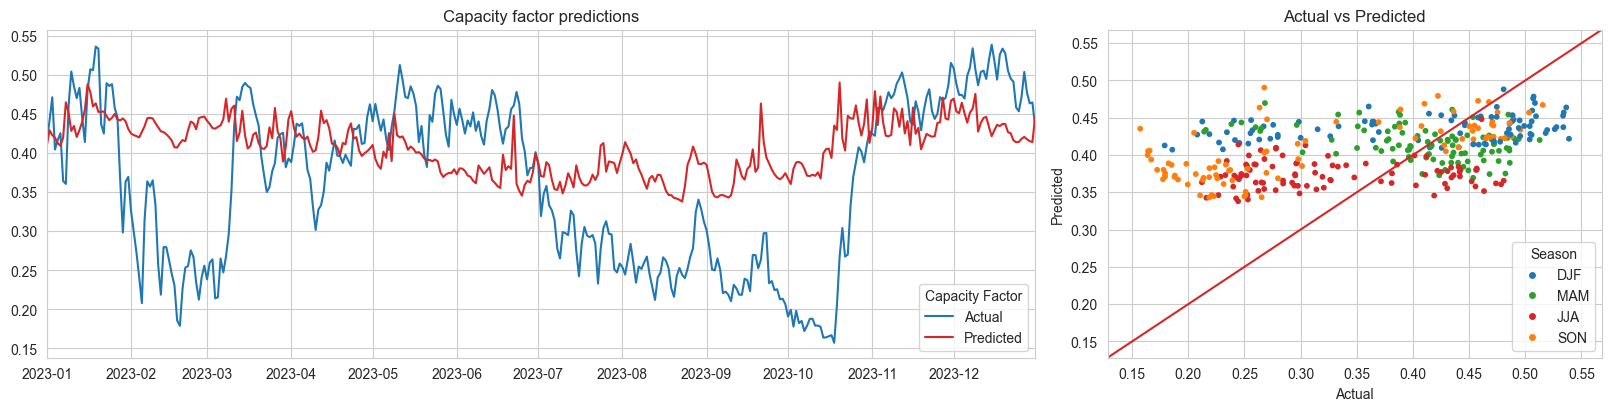

In [45]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(random_state=0)
sgd.fit(X_train_std, y_train)  # apprentissage supervisé

y_pred = sgd.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["SGD"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Paramètres

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")

print()

display_result(y_test, y_pred)

Gradient boosting sans GridSearch

R2: -0.032903
MSE: 0.011144



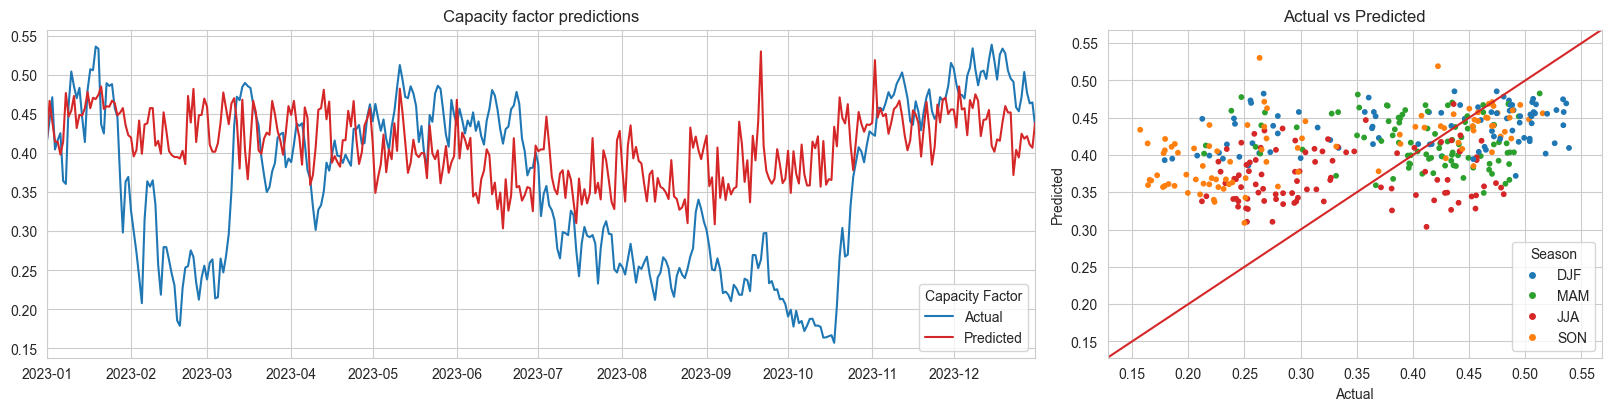

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train_std, y_train)  # apprentissage supervisé

y_pred = gbr.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["GBR"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Paramètres

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")

print()

display_result(y_test, y_pred)

Gradient Boosting avec GridSearch : optimisation du learning rate, de max depth et de n estimators. On retient les paramètres : learning rate = ; n estimators = ; max depth = .

In [75]:
params = {'n_estimators': np.arange(1,100,5),
          'max_depth': np.arange(1,100,5),
          'learning_rate' : np.linspace(0,1,100)
}

cv = GridSearchCV(gbr, param_grid=params, n_jobs = 2)  # recherche par grille. CV pour cross validation.
cv.fit(X_train_std, y_train)  # apprentissage supervisé

y_pred = cv.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["GBRCV"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print(cv.best_params_)
print()

display_result(y_test, y_pred)

KeyboardInterrupt: 

Avec K-fold-validation. On retient les paramètres : learning rate = ; max depth = ; n estimators = .

In [ ]:
from sklearn.model_selection import GroupKFold

params = {'n_estimators': np.arange(1,100,5),
              'max_depth': np.arange(1,100,5)
           'learning_rate' : np.linspace(0,1,100)
}


gkf=GroupKFold(n_splits=8, shuffle = False)

n_samples = X_train.shape[0]            # 2920
n_groups = 8
group_size = n_samples // n_groups      # 365

groups = np.repeat(np.arange(n_groups), group_size)

# modèle d'arbre de décision
cv = GridSearchCV(gbr, param_grid=params, n_jobs = 2, cv = gkf)  # recherche par grille. CV pour cross validation.
cv.fit(X_train_std, y_train, groups = groups)  # apprentissage supervisé

y_pred = cv.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RFRCVK-folds"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print(cv.best_params_)
print()

display_result(y_test, y_pred)

Avec LOOCV. On retient les paramètres : n estimators = ; max depth = ; learning rate = . 

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()

params = {'n_estimators': np.arange(1,100),
              'max_depth': np.arange(1,100)
           'learning_rate' : np.linspace(0,1,100)
}

n_samples = X_train_std.shape[0]            # 2920
n_groups = 8
group_size = n_samples // n_groups      # 365

groups = np.repeat(np.arange(n_groups), group_size)

# modèle d'arbre de décision
cv = GridSearchCV(gbr, param_grid=params, n_jobs = 2, cv = logo)  # recherche par grille. CV pour cross validation.
cv.fit(X_train_std, y_train, groups = groups)  # apprentissage supervisé

y_pred = cv.predict(X_test_std)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RFRCVK-folds"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print(cv.best_params_)
print()

display_result(y_test, y_pred)